In [66]:
#imports

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
#load preprocesssed tickets
path = 'Datasets/endava-tickets.csv'
tickets = pd.read_csv(path)
tickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [27]:
# value count of each category
tickets['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [28]:
#setting column to predict
column_to_predict = 'category'

In [32]:
min_data_per_class = 100

In [33]:
# removing poorly represented classes
text_columns = "body"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(tickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(tickets[column_to_predict]))))
bytag = tickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.body > min_data_per_class].index
tickets = tickets[tickets[column_to_predict].isin(tags)]
print(
    "Shape of dataset after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(tickets.shape)
)
print(
    "Number of classes after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(len(np.unique(tickets[column_to_predict])))
)

Shape of dataset before removing classes with less then 100 rows: (48549, 9)
Number of classes before removing classes with less then 100 rows: 13
Shape of dataset after removing classes with less then 100 rows: (48423, 9)
Number of classes after removing classes with less then 100 rows: 8


In [34]:
# value count of each category
tickets['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
Name: category, dtype: int64

In [37]:
labelData = tickets[column_to_predict]
data = tickets[text_columns]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size = 0.2)

In [42]:
class StemmedCountVectorizer(CountVectorizer):
    def biuld_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english")
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [45]:
# count vectorizer
count_vect = CountVectorizer()
vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(38738, 11586)

In [47]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(38738, 11586)

In [52]:
print("Training NB classifier")
text_clf = Pipeline([
    ('vect', count_vect),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(fit_prior=True))
])
text_clf = text_clf.fit(train_data, train_labels)

Training NB classifier


In [68]:
print("Evaluating model")
prediction = text_clf.predict(test_data)
prediction_acc = np.mean(prediction == test_labels)
print("Confusion matrix: ")
print(metrics.confusion_matrix(test_labels, prediction))
print("Mean " + str(prediction_acc))



Evaluating model
Confusion matrix: 
[[   0   22   10    0    0    0    0    0]
 [   0 6745   90   15    0    0    0    0]
 [   0  766 1112    1    0    0    0    0]
 [   0  432   45   45    0    0    0    0]
 [   0  172    3    0    1    0    0    0]
 [   0   43    2    2    0   10    0    0]
 [   0   17   16    0    0    0    0    0]
 [   0  123    3    1    0    0    0    9]]
Mean 0.817965926690759


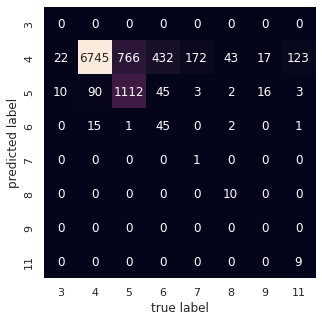

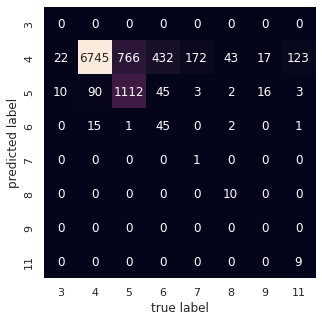

In [69]:

mat = confusion_matrix(test_labels, prediction)
plt.figure(figsize=(5, 5))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
xticklabels=np.unique(test_labels),
yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show(())

In [67]:
print(classification_report(test_labels, prediction,
                            target_names=np.unique(test_labels)))

/home/abhinavdeep/jupyter-notebook/virtual-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: object of type 'numpy.int64' has no len()